<a href="https://colab.research.google.com/github/olinml2024/notebooks/blob/main/ML24_Day13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy Problem

We've done a mini-lecture to explain some key ideas behind the notion of word embeddings.  Now we're going to actually see some in action.  In this notebook, we are going to start with a toy problem to help us wrap our minds around the key ideas.

We'll begin by embedding not words but single letters.  We decided to start with this because we wanted to make our first example as simple as possible.  First, we will create a dataset consisting of 10,000 letter patterns.  Each letter pattern will either consist of two vowels, a consonant, and then two more vowels (VVCVV) or two consontants, a vowel, and then two more consontants (CCVCC).

After generating these patterns, we'll print some out so you can see what they look like.

In [2]:
import torch
import random
import numpy as np

# patterns are VVCVV CCVCC
n_train = 10000
vowels = set('aeiou')
consonants = set('bcdfghjklmnpqrstvwxyz')

def make_patterns(n):
    X = []
    for i in range(n):
        if random.randint(0, 1) == 1:
            random_vowel = random.choice(tuple(vowels))
            four_random_consonants = np.random.choice(tuple(consonants), 4)
            X.append([four_random_consonants[0], four_random_consonants[1], random_vowel, four_random_consonants[2], four_random_consonants[3]])
        else:
            random_consonant = random.choice(tuple(consonants))
            four_random_vowels = np.random.choice(tuple(vowels), 4)
            X.append([four_random_vowels[0], four_random_vowels[1], random_consonant, four_random_vowels[2], four_random_vowels[3]])
    return X

X = make_patterns(n_train)
print(X)

[['k', 'w', 'a', 'p', 't'], ['r', 'd', 'u', 'r', 'b'], ['p', 'b', 'a', 'n', 'y'], ['k', 's', 'e', 'r', 'h'], ['i', 'o', 'l', 'u', 'e'], ['i', 'i', 'h', 'a', 'u'], ['o', 'u', 'h', 'o', 'o'], ['v', 'c', 'a', 'h', 'z'], ['i', 'a', 's', 'i', 'u'], ['c', 'q', 'i', 'x', 't'], ['u', 'u', 'p', 'a', 'e'], ['u', 'a', 'x', 'u', 'a'], ['t', 'y', 'o', 'y', 'v'], ['i', 'o', 'q', 'e', 'i'], ['o', 'i', 'k', 'e', 'i'], ['a', 'i', 't', 'a', 'o'], ['k', 'v', 'a', 'q', 'b'], ['y', 'z', 'u', 't', 'y'], ['x', 'm', 'u', 's', 's'], ['i', 'i', 'p', 'e', 'a'], ['x', 'q', 'u', 'x', 'b'], ['u', 'i', 'f', 'u', 'o'], ['m', 'x', 'i', 'k', 'p'], ['s', 's', 'u', 'j', 'j'], ['i', 'u', 'h', 'u', 'a'], ['h', 'c', 'e', 'r', 'l'], ['h', 'y', 'i', 'y', 'm'], ['b', 'j', 'u', 't', 'l'], ['x', 'c', 'i', 'q', 'p'], ['d', 'f', 'o', 'd', 'n'], ['q', 'k', 'u', 'd', 'j'], ['e', 'i', 'y', 'a', 'u'], ['s', 'w', 'a', 'd', 'c'], ['w', 'd', 'o', 'b', 'h'], ['o', 'u', 'q', 'i', 'e'], ['a', 'o', 'b', 'e', 'e'], ['t', 'y', 'a', 's', 't'], 

Next, were going to train a character embedding.  We begin by defining two dictionaries.  The first, called ``tokenize`` is for turning each of the 26 letters in to a token (represented as an integer from 0-25).  The second, called ``detokenize``, implements the inverse operation (from integer to letter).

In [8]:
tokenize = dict(zip(list(vowels) + list(consonants), list(range(26))))
detokenize = dict(zip(tokenize.values(), tokenize.keys()))

print(tokenize['a'])                    # should be 0
print(detokenize[tokenize['a']])        # should get back to 'a'

0
a


Now, we can define what's called the skip-gram model.  The skip-gram model, in this case, attempts to use the center letter to predict the surrounding letters.  For example, if we have a CCVCC pattern, we would want to be able to take the center letter (vowel) as input and predict the identity of the surrounding consonants.

You may be thinking this is an impossible task.  You'd be right.  Let's take a minute to discuss this.

Nevertheless, we can define a model that does its best to solve the task.  Let's take a look at this model in detail.

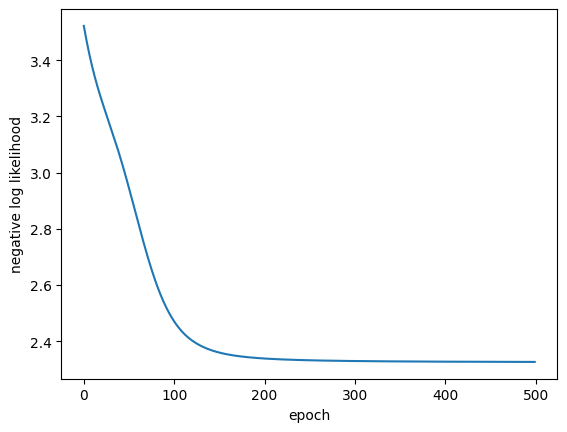

In [15]:
from torch.nn import Module
from torch import nn

class SkipGram(Module):
    def __init__(self, n_embd=2):
        """
        Create the SkipGram model.
        Args:
          n_embd: the number of dimensions to use for our character embeddings.
        """
        super().__init__()
        # hardcoding 26 (note: could also use len(tokenize))
        self.embedding = nn.Embedding(26, n_embd)
        self.output = nn.Linear(n_embd, 26)

    def __call__(self, x):
        """
        The forward pass of our model
        Args:
          x: the center letter (represented as an integer from 0-25)

        Returns: the log probability of each of the 26 letters.
        """
        x = self.embedding(x)
        x = self.output(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

model = SkipGram()

# start off by tokenize each letter in each of our 10,000 patterns
X_tok = torch.tensor([[tokenize[letter] for letter in x] for x in X])
# we are predicting the first two and last two characters
y_tok = torch.hstack((X_tok[:,0:2], X_tok[:,3:5]))
X_tok = X_tok[:,2]

optimizer = torch.optim.Adam(model.parameters(), lr=10**-2)
n_epochs = 500
losses = np.zeros((n_epochs,1))
for n in range(n_epochs):
    log_probs = model(X_tok)
    # this is fancy syntax grabs the corresponding log probabilities corresponding
    # to the letters that actually surrounded our center letter.
    loss = -log_probs.gather(1,y_tok).mean()
    model.zero_grad()
    loss.backward()
    losses[n] = loss.item()
    optimizer.step()

plt.plot(range(n_epochs), losses)
plt.ylabel('negative log likelihood')
plt.xlabel('epoch')
plt.show()

Next, we can look at the embeddings themselves as a way to understand what the model learned.

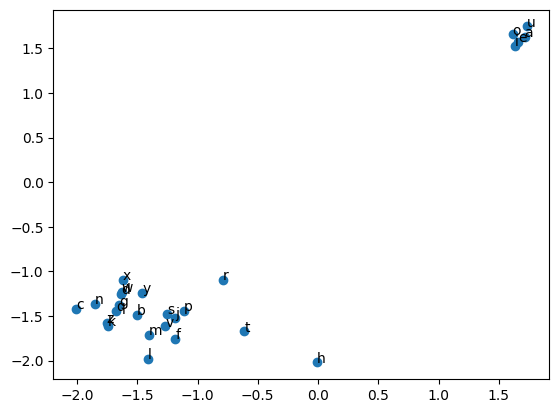

In [16]:
import matplotlib.pyplot as plt
embedded = model.embedding(torch.tensor(list(tokenize.values()))).detach().numpy()
fig, ax = plt.subplots()
ax.scatter(embedded[:,0], embedded[:,1])
text = list(tokenize.keys())
for i in range(embedded.shape[0]):
    ax.annotate(text[i], (embedded[i,0], embedded[i,1]))

# Skip-grams on Words

We can extend these same ideas to a little bit more interesting problem.  We begin with an old dataset of text called [the Penn Tree Bank](https://catalog.ldc.upenn.edu/LDC99T42).

You can use the link above for a more complete description, but a very high-level overview is that the dataset contains "one million words of 1989 Wall Street Journal material."  This dataset is convenient in that the sample we will load has already been tokenized (case removed, uncommon words replaced by a special symbol, etc.).

We'll repeat largely the same steps as we did for our letter example but we'll use word as a our unit of analysis. We'll also build in support for using the GPU, batches of data, and allow the context window size to be adjusted.


In [21]:
!wget https://raw.githubusercontent.com/tomsercu/lstm/refs/heads/master/data/ptb.train.txt -O ptb.train.txt
!wget https://raw.githubusercontent.com/tomsercu/lstm/refs/heads/master/data/ptb.test.txt -O ptb.test.txt
with open('ptb.train.txt') as f:
    text = f.read()
words = text.split()
unique_words = set(words)

--2024-10-21 05:12:41--  https://raw.githubusercontent.com/tomsercu/lstm/refs/heads/master/data/ptb.train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5101618 (4.9M) [text/plain]
Saving to: ‘ptb.train.txt’

ptb.train.txt       100%[===================>]   4.87M  --.-KB/s    in 0.03s   

2024-10-21 05:12:41 (153 MB/s) - ‘ptb.train.txt’ saved [5101618/5101618]

--2024-10-21 05:12:41--  https://raw.githubusercontent.com/tomsercu/lstm/refs/heads/master/data/ptb.test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 449945 (43

In [ ]:
tokenize_words = dict(zip(list(unique_words), list(range(len(unique_words)))))
detokenize_words = dict(zip(tokenize_words.values(), tokenize_words.keys()))

class SkipGram_words(Module):
    def __init__(self, n_embd=2):
        super().__init__()
        self.embedding = nn.Embedding(len(unique_words), n_embd)
        self.linear_1 = nn.Linear(n_embd, len(unique_words))

    def __call__(self, x):
        x = self.embedding(x)
        x = self.linear_1(x)
        x = nn.functional.log_softmax(x, dim=1)
        return x

model = SkipGram_words(n_embd=100)
sliding_window_size = 9
assert(sliding_window_size % 2 == 1)
center_idx = (sliding_window_size-1)//2

all_contexts = []
# use sliding window
for i in range(0, len(words)-sliding_window_size+1):
    all_contexts.append([tokenize_words[w] for w in words[i:i+sliding_window_size]])

X_tok = torch.tensor(all_contexts)
y_tok = torch.hstack((X_tok[:,:center_idx], X_tok[:,center_idx+1:]))
X_tok = X_tok[:,center_idx]

optimizer = torch.optim.Adam(model.parameters(), lr=10**-3, weight_decay=10**-4)

trainset = torch.utils.data.TensorDataset(X_tok, y_tok)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
n_epochs = 10
for n in range(n_epochs):
    running_loss = 0.0
    total_processed = 0
    for i, data in enumerate(trainloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        log_probs = model(inputs.to(device))
        loss = -log_probs.gather(1,labels.to(device)).mean()
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        total_processed += inputs.shape[0]
        if i % 100 == 0:
            print(total_processed/len(all_contexts))
            print(f"{n} {running_loss/(i+1)}")

0.00014422323954691368
0 9.379720687866211
0.01456654719423828
0 9.009473744005259
0.02898887114892965
0 8.760005324634154
0.043411195103621014
0 8.567152733026548
0.05783351905831238
0 8.412904351726732
0.07225584301300375
0 8.289290834567742
0.08667816696769512
0 8.183284276337076
0.10110049092238649
0 8.09149284811741
0.11552281487707786
0 8.012440293320408
0.12994513883176922
0 7.943074152287051
0.1443674627864606
0 7.8790633085367086
0.15878978674115196
0 7.822597485905231
0.17321211069584333
0 7.771422967823419
0.1876344346505347
0 7.722622475561777
0.20205675860522607
0 7.678348627369545
0.21647908255991744
0 7.638142237577496
0.2309014065146088
0 7.6000042095696605
0.24532373046930017
0 7.564934803414947
0.2597460544239915
0 7.532823304743451
0.2741683783786829
0 7.501657194240917
0.28859070233337425
0 7.473164527431718
0.30301302628806565
0 7.447458061134742
0.317435350242757
0 7.423041295810268
0.3318576741974484
0 7.39959779442626
0.3462799981521397
0 7.378505479986595
0.360

We can use the embeddings of the 500 most common words and look for the most similar word for each.

In [27]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter

c = Counter(words)
most_common_words = list(map(lambda k: k[0], c.most_common(500)))
most_common_word_inds = torch.tensor(list(map(lambda k: tokenize_words[k[0]],
                                              c.most_common(500)))).to(device)

common_word_embeddings = model.embedding(most_common_word_inds).detach().cpu().numpy()
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(common_word_embeddings)
distances, indices = nbrs.kneighbors(common_word_embeddings)
closest_map = dict(zip(most_common_words, [most_common_words[ind] for ind in indices[:,1]]))

In [28]:
closest_map

{'the': 'certain',
 '<unk>': 'my',
 'N': 'down',
 'of': 'john',
 'to': 'give',
 'a': 'been',
 'in': 'program',
 'and': 'has',
 "'s": 'earthquake',
 'that': 'demand',
 'for': 'yen',
 '$': 'far',
 'is': 'before',
 'it': 'rise',
 'said': 'into',
 'on': 'my',
 'by': 'those',
 'at': 'come',
 'as': 'fell',
 'from': 'last',
 'million': 'later',
 'with': 'south',
 'mr.': 'cash',
 'was': 'union',
 'be': 'official',
 'are': 'into',
 'its': 'later',
 'he': 'bond',
 'but': 'south',
 'has': 'expects',
 'an': 'john',
 "n't": 'yen',
 'will': 'rise',
 'have': 'yen',
 'new': 'ual',
 'or': 'little',
 'company': 'investment',
 'they': 'issue',
 'this': 'markets',
 'year': 'loans',
 'which': 'by',
 'would': 'sale',
 'about': 'three',
 'says': 'workers',
 'more': 'though',
 'were': 'into',
 'market': 'british',
 'billion': 'rise',
 'his': 'rate',
 'had': 'period',
 'their': 'issue',
 'up': 'less',
 'u.s.': 'should',
 'one': 'still',
 'than': 'analysts',
 'who': 'rise',
 'some': 'while',
 'been': 'john',
 '